### Day 3 - RGB blur

In [ ]:
import numpy as np
from PIL import Image

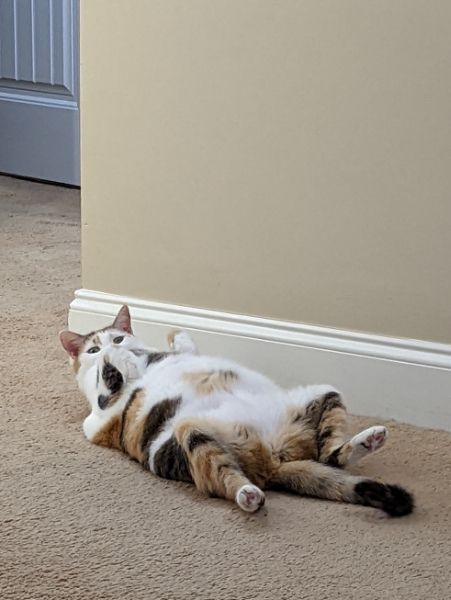

In [ ]:
image = Image.open("../cat-1.jpg")
image

In [ ]:
# Convert PIL Image to numpy array
img_array = np.array(image)
print(f"Image shape: {img_array.shape}")

height = img_array.shape[0]
width = img_array.shape[1]

Image shape: (600, 451, 3)


In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
from pathlib import Path

[day_03_blurry.cu](https://github.com/xl0/cuda-100/blob/master/nbs/day_03_blurry.cu)

In [ ]:
#|output: asis
#|echo: false

c_code = Path('day_03_blurry.cu').read_text()
print(f'''
::: {{.code-block}}
```
{c_code}
```
:::
''')


::: {.code-block}
```
#include <stdint.h>
#include <stdio.h>

__global__ void rgb_blur(uint8_t *in, uint8_t *out, uint32_t w, uint32_t h, uint32_t blur) {

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < w && y < h) {
        int idx = (y * w + x);

        for (int ch = 0; ch < 3; ch++) {
            uint32_t v = 0;
            for (int j = -blur; j <= (int)blur; j++) {
                for (int i = -blur; i <= (int)blur; i++) {
                    if (y + j >= 0   &&
                        y + j < h    &&
                        x + i >= 0   &&
                        x + i < w) {
                            v += in[ ((y + j) * w + x + i)*3 + ch];
                        }
                }
            }

            out[idx*3+ch] = (uint8_t)(v / ((2*blur + 1) * (2*blur + 1)));
        }
    }
}


```
:::



In [ ]:
BLOCK_SIZE_X = 16
BLOCK_SIZE_Y = 16

try:
    ctx = device.make_context()

    mod = SourceModule(Path("day_03_blurry.cu").read_text(),
        options=[
            '-Xcompiler', '-Wall',
            '-Xcompiler', '-Wextra',
            '-Xcompiler', '-Wsign-conversion',
            '-Xcompiler', '-Wcast-qual',
            '-Xcompiler', '-Wunused-parameter',
            '-Xcompiler', '-Wdouble-promotion',
            '-Xcompiler', '-Wformat=2',
            '-Xcompiler', '-Wfloat-equal',
            '-Xcompiler', '-Wshadow'
        ]
        )

    rgb_blur = mod.get_function("rgb_blur")

    gpu_in = cuda.mem_alloc_like(img_array)
    gpu_out = cuda.mem_alloc_like(img_array)


    cuda.memcpy_htod(gpu_in, img_array)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (
        ((width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X),
        ((height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y),
        1
    )

    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Image dimensions: {width}x{height}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")


    rgb_blur(gpu_in, gpu_out, np.uint32(width), np.uint32(height), np.int32(3), block=block_size, grid=grid_size)

    cpu_out = np.empty_like(img_array)
    cuda.memcpy_dtoh(cpu_out, gpu_out)


finally:
    ctx.pop()
    ctx.detach()

Grid size: (29, 38, 1)
Block size: (16, 16, 1)
Image dimensions: 451x600
Total threads: 282112


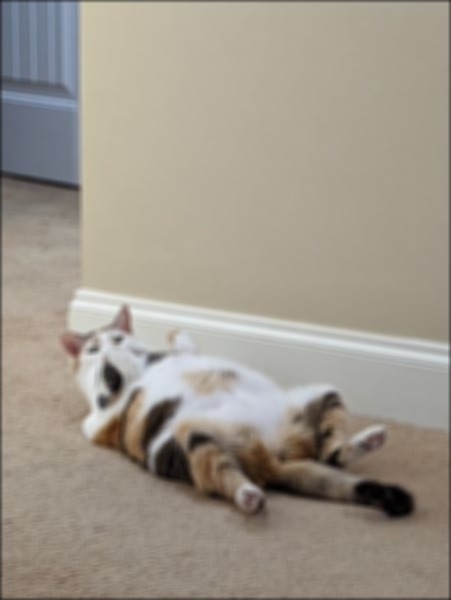

In [ ]:
Image.fromarray(cpu_out)